# Flux Light-Curve example (GRB)

**To run this, you need the following files, which can be downloaded using the first few cells of this notebook:**
- orientation file (20280301_3_month_with_orbital_info.ori)       
- binned data (grb_bkg_binned_data.hdf5, grb_binned_data.hdf5, & bkg_binned_data_1s_local.hdf5)     
- detector response 
(SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip)     

**The binned data are simulations of GRB090206620 and albedo photon background produced using the COSI SMEX mass model. The detector response needs to be unzipped before running the notebook.**

This notebook slices a COSI dataset into time slices, using two possible criteria (i.e. equal length slices or slices with a minum signal to noise). Perform a fit with 3ML in each of them. It finally examines the time series of flux and fitted spectral parameters. For each slicing case (eqslice_ and minsnslice_), it saves: a txt file of the raw lightcurves (lc.dat); a plot at each iteration of the fit (fit_i.pdf); a txt file (spec_lc.dat) including the mid-point of each time bin with errors, the total counts, the fluxes with asymmetric errors, the fitted parameters with symmetric errors; two plots (raw_flux_counts_lc.pdf, specpars_bk_lc.pdf) of the final time series.

In [1]:
from cosipy import COSILike, BinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.response.FullDetectorResponse import FullDetectorResponse
from cosipy.util import fetch_wasabi_file

from scoords import SpacecraftFrame

from astropy.time import Time, TimeDelta
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import poisson_conf_interval

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from threeML import *
from threeML import Band, PointSource, Model, JointLikelihood, DataList
from cosipy import Band_Eflux
from astromodels import Parameter

from pathlib import Path

import os
import subprocess
home=os. path. expanduser("~")
home

23:30:57 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=615080;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=297251;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=756543;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=886395;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

/Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


23:30:58 WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=696157;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=474224;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

/Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


23:30:58 INFO      Starting 3ML!                                                                     ]8;id=222585;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=742282;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=636717;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=245672;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=220858;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=295877;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=694131;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=917516;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   ROOT minimizer not available                                                ]8;id=296657;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=147650;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=283465;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=114741;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=620213;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=596745;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

23:30:59 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=91030;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=839637;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=428917;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=239968;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=166982;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=757810;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

23:30:59 WARNING   No fermitools installed                                              ]8;id=341504;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=856241;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=757740;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=125771;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=57276;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=396920;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=434502;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=1625;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

'/Users/lauradigesu'

## A simple function to create equal sized time slices.


This function slices a time interval in N bins.

In [2]:
"""
INPUT:
tstart, tstop: edges of the time interval to be sliced.
nbins: number of bins to create.
OUTPUT:
tmins,tmaxs: arrays containing the edges of the slices.
"""
def make_eqsize_tslices(tstart,tstop,nbins):
    dt=(tstop-tstart)/nbins
    tmins = np.array([], dtype=float)# Initialize as empty numpy arrays
    tmaxs=np.array([], dtype=float)# Initialize as empty numpy arrays
    #
    for i in range(nbins):
        tmin=tstart+i*dt
        tmax=tmin+dt
        tmins = np.append(tmins, tmin)
        tmaxs=np.append(tmaxs, tmax)
    return(tmins,tmaxs)




## A more complex function to create time slices with a minimum signal to noise.
This function iterate over a time grid, to determine slices with a minimum signal to noise.In the future we may have different binning methods with suitable criteria

In [3]:
"""
INPUT:
tstart,tstop: edges of the time interval to be sliced.
yaml_path,hdf5_path: path to the COSI binned dataset and corresponding yaml file.
min_sn: minimum signal to noise required in each slice.
max_slices: maximum number of slices to determine the time grid of the computation.
OUTPUT:
tmins,tmaxs: arrays containing the edges of the slices.
"""
def make_minsn_tslices(tstart, tstop, yaml_path, hdf5_path, min_sn, max_slices):
    step = (tstop - tstart) / max_slices
    tmins = np.array([], dtype=float)
    tmaxs = np.array([], dtype=float)
    #
    data = BinnedData(yaml_path)
    data.load_binned_data_from_hdf5(hdf5_path)
    #
    tmax=tstart
    for i in range (max_slices):
        tmin=tmax
        tmax_i=tstart+(i+1)*step
        #
        sou_min = np.where(data.binned_data.axes['Time'].edges.value >= tmin)[0][0]
        sou_max_all = np.where(data.binned_data.axes['Time'].edges.value <= tmax_i)
        y=len(sou_max_all[0])-1
        sou_max=np.where(data.binned_data.axes['Time'].edges.value <= tmax_i)[0][y]
        data_sliced=data.binned_data.slice[{'Time':slice(sou_min,sou_max)}].project('Em')
        #
        #
        signal=np.sum(data_sliced.todense().contents)
        noise=np.sqrt(signal)
        #
        sn=signal/noise
        if (sn >= min_sn and tmax_i<tstop):
            tmins = np.append(tmins, tmin)
            tmax=tmax_i
            tmaxs = np.append(tmaxs, tmax)
        elif(tmax_i==tstop):
            tmaxs[-1] = tmax_i
    return(tmins, tmaxs)
 

## Download and read in binned data

Define the path to the directory containing the data, detector response, orientation file, and yaml files if they have already been downloaded, or the directory to download the files into. Define a directory where you want to save the outputs. Defaults are ./cosidata and ./cosiprod

In [4]:
current=os.getcwd()
indir=str(current+"/cosidata")
data_path = Path(indir)
odir= str(current+"/cosiprod")

Download the orientation file (684.38 MB)

In [5]:
#fetch_wasabi_file('COSI-SMEX/DC2/Data/Orientation/20280301_3_month_with_orbital_info.ori', output=str(data_path / '20280301_3_month_with_orbital_info.ori'))

Download the binned GRB+background data (75.73 KB)

In [6]:
#fetch_wasabi_file('COSI-SMEX/cosipy_tutorials/grb_spectral_fit_local_frame/grb_bkg_binned_data.hdf5', output=str(data_path / 'grb_bkg_binned_data.hdf5'))

Download the binned GRB data (76.90 KB)

In [7]:
#fetch_wasabi_file('COSI-SMEX/cosipy_tutorials/grb_spectral_fit_local_frame/grb_binned_data.hdf5', output=str(data_path / 'grb_binned_data.hdf5'))

Download the binned background data (255.97 MB)

In [8]:
#fetch_wasabi_file('COSI-SMEX/cosipy_tutorials/grb_spectral_fit_local_frame/bkg_binned_data_1s_local.hdf5', output=str(data_path / 'bkg_binned_data_1s_local.hdf5'))

Download the response file (839.62 MB) and unzip it in indir.

In [9]:
#
#fetch_wasabi_file('COSI-SMEX/DC2/Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip', output=str(data_path / 'SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip'))
#
#filename="SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip"
#filepath = os.path.join(indir, filename)
#Unzip
#subprocess.run(["unzip", filepath])
#

Create BinnedData objects for the GRB only, GRB+background, and background only. The GRB only simulation is not used for the spectral fit, but can be used to compare the fitted spectrum to the source simulation

In [10]:
grb = BinnedData(data_path / "grb.yaml")
grb_bkg = BinnedData(data_path / "grb.yaml")
bkg = BinnedData(data_path / "background.yaml")

Load binned .hdf5 files

In [11]:
grb.load_binned_data_from_hdf5(binned_data=data_path / "grb_binned_data.hdf5")
grb_bkg.load_binned_data_from_hdf5(binned_data=data_path / "grb_bkg_binned_data.hdf5")
bkg.load_binned_data_from_hdf5(binned_data=data_path / "bkg_binned_data_1s_local.hdf5")

Define the path to the detector response

In [12]:
dr = str(data_path / "SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5") # path to detector response
ori = SpacecraftFile.parse_from_file(data_path/"20280301_3_month_with_orbital_info.ori")

In [13]:
data = grb_bkg.binned_data
data.project('Em', 'Phi', 'PsiChi')

Define the path the injected spectral model, and inizialize the parameters of the fits to something reasonable.

In [14]:
#
#model injected
#
alpha_inj = -0.360
beta_inj = -11.921
E0_inj = 288.016 * u.keV
xp_inj = E0_inj * (alpha_inj + 2)
piv_inj = 1. * u.keV
K_inj = 0.283 / u.cm / u.cm / u.s / u.keV

spectrum_inj = Band()

spectrum_inj.beta.min_value = -15.0

spectrum_inj.alpha.value = alpha_inj
spectrum_inj.beta.value = beta_inj
spectrum_inj.xp.value = xp_inj.value
spectrum_inj.K.value = K_inj.value
spectrum_inj.piv.value = piv_inj.value

spectrum_inj.xp.unit = xp_inj.unit
spectrum_inj.K.unit = K_inj.unit
spectrum_inj.piv.unit = piv_inj.unit


#Model to be fitted
# # Setting parameters to something reasonable helps the fitting to converge\n",

beta = -3

l = 93.
b = -53.

alpha = -1                                      
xp = 450. * u.keV
piv = 500. * u.keV
K = 1 / u.cm / u.cm / u.s / u.keV

spectrum = Band()

spectrum.beta.min_value = -15.0

spectrum.alpha.value = alpha
spectrum.beta.value = beta
spectrum.xp.value = xp.value
spectrum.K.value = K.value
spectrum.piv.value = piv.value

spectrum.xp.unit = xp.unit
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit


Move to the product directory.

In [15]:
os.chdir(odir)

Find time window of the GRB data and make a raw lightcurve to be plotted as a comparison.

In [16]:
grb_bkg.get_raw_lightcurve(binned_data=data_path / "grb_binned_data.hdf5", output_name="lc")
time, rate = np.loadtxt("lc.dat", skiprows=1, unpack=True)
tstart=np.min(time)
tstop=np.max(time)

# Time series in equal size time slices



Now we use either the make_eqsize_tbins to determine the edges of N time slices. We used them to slice the data in time. We perform N spectral fits to determine fluxes and spectral parameters as a function of time. We save a plot of the fit at each iteration, to allow the user to inspect the goodness of the fit. We save all the time series in a text file.

23:39:48 INFO      set the minimizer to minuit                                             ]8;id=260414;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=400371;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


23:39:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=420929;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=471612;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

         WARNING   49.519999999999996 percent of samples have been thrown away because     ]8;id=543518;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=202191;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Band.K,(8.7 -0.6 +0.7) x 10^-2,1 / (cm2 keV s)
source.spectrum.main.Band.alpha,(-2.2 +/- 0.6) x 10^-1,
source.spectrum.main.Band.xp,(4.71 +/- 0.05) x 10^2,keV
source.spectrum.main.Band.beta,-7.3 +/- 2.1,
background_cosi,(0 +/- 6) x 10^-6,


Correlation matrix:

1.00,0.97,-0.37,0.21,-0.00
0.97,1.00,-0.16,0.19,0.00
-0.37,-0.16,1.00,-0.17,0.00
0.21,0.19,-0.17,1.00,-0.00
-0.00,0.00,0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,38442.271228
total,38442.271228


Values of statistical measures:

,statistical measures
AIC,76882.542456
BIC,76884.542456


processing MLE analyses:   0%|                                                           | 0/1 [00:00<?, ?it/s…


WARNING RuntimeWarning: divide by zero encountered in true_divide


WARNING RuntimeWarning: invalid value encountered in true_divide



23:39:57 INFO      set the minimizer to minuit                                             ]8;id=735102;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=737064;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


23:40:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=153566;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=607925;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

23:40:19 WARNING   50.82 percent of samples have been thrown away because they failed the  ]8;id=327018;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=378357;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Band.K,(5.9 -1.0 +1.2) x 10^-3,1 / (cm2 keV s)
source.spectrum.main.Band.alpha,(-6.2 +/- 1.5) x 10^-1,
source.spectrum.main.Band.xp,(4.83 -0.18 +0.19) x 10^2,keV
source.spectrum.main.Band.beta,-5.4 +/- 1.3,
background_cosi,(0.0 +/- 1.7) x 10^-6,


Correlation matrix:

1.00,0.97,-0.31,0.09,-0.00
0.97,1.00,-0.09,0.07,-0.00
-0.31,-0.09,1.00,-0.13,0.00
0.09,0.07,-0.13,1.00,0.00
-0.00,-0.00,0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,8496.776961
total,8496.776961


Values of statistical measures:

,statistical measures
AIC,16991.553922
BIC,16993.553922


processing MLE analyses:   0%|                                                           | 0/1 [00:00<?, ?it/s…


WARNING RuntimeWarning: divide by zero encountered in true_divide


WARNING RuntimeWarning: invalid value encountered in true_divide



23:40:21 INFO      set the minimizer to minuit                                             ]8;id=295001;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=557261;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


23:40:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=484997;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=376179;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

         WARNING   95.6 percent of samples have been thrown away because they failed the   ]8;id=369790;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=297232;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Band.K,(1.7 -0.7 +1.2) x 10^-3,1 / (cm2 keV s)
source.spectrum.main.Band.alpha,(-2 +/- 4) x 10^-1,
source.spectrum.main.Band.xp,(4.7 +/- 0.4) x 10^2,keV
source.spectrum.main.Band.beta,(-1 +/- 6) x 10,
background_cosi,(0 +/- 9) x 10^-7,


Correlation matrix:

1.00,0.97,-0.37,-0.00,0.00
0.97,1.00,-0.15,-0.00,0.00
-0.37,-0.15,1.00,0.00,0.00
-0.00,-0.00,0.00,1.00,-0.00
0.00,0.00,0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,1882.936703
total,1882.936703


Values of statistical measures:

,statistical measures
AIC,3763.873405
BIC,3765.873405


processing MLE analyses:   0%|                                                           | 0/1 [00:00<?, ?it/s…


WARNING RuntimeWarning: divide by zero encountered in true_divide


WARNING RuntimeWarning: invalid value encountered in true_divide



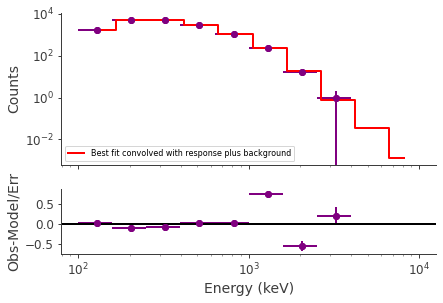

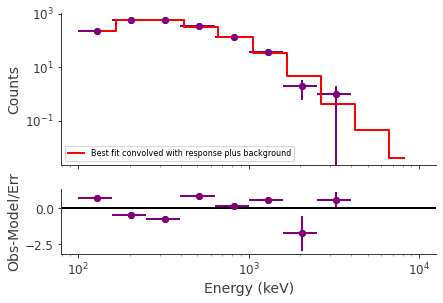

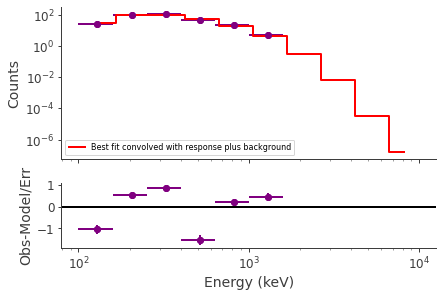

In [18]:
#Create equal sized time slices. Change nslices as you wish to make less or more slices.
nslices=3
tmins,tmaxs=make_eqsize_tslices(tstart,tstop,nslices)
#
#Initialize empty vectors that will be filled at each step.
#
tmins_lc=np.array([])
tmaxs_lc=np.array([])
tmeds_lc=np.array([])
e_tmeds_lc=np.array([])
#
cts_lc=np.array([])
fls=np.array([])
e_low_fls=np.array([])
e_hi_fls=np.array([])
#
pars_bk=np.array([])
epars_bk=np.array([])
#
par_epar=np.array([])
#
for i in range(len(tmaxs)):
    #
    #LOOP over our N time bins.
    #
    #
    #The background is taken in a larger time window than the GRB to have enough counts.
    #
    bkg_tmin = 1842597310.0
    bkg_tmax = 1842597550.0
    bkg_min = np.where(bkg.binned_data.axes['Time'].edges.value == bkg_tmin)[0][0]
    bkg_max = np.where(bkg.binned_data.axes['Time'].edges.value == bkg_tmax)[0][0]
    #
    #Slice the orientation file into the time interval
    #
    ori_min = Time(tmins[i],format = 'unix')
    ori_max = Time(tmaxs[i],format = 'unix')
    sc_orientation = ori.source_interval(ori_min, ori_max)
    #
    #
    #Find the index of time axes corresponding to the limits of the tmins[i],tmaxs[i].
    #These are used to slice the data in time in the fit setup.
    #
    sou_min = np.where(grb_bkg.binned_data.axes['Time'].edges.value >= tmins[i])[0][0]
    sou_max_all = np.where(grb_bkg.binned_data.axes['Time'].edges.value <= tmaxs[i])
    y=len(sou_max_all[0])-1
    sou_max=np.where(grb_bkg.binned_data.axes['Time'].edges.value <= tmaxs[i])[0][y]
    #
    #Save the time bin edges and middle points for plotting later.
    #
    tmin_lc=grb_bkg.binned_data.axes['Time'].edges.value[sou_min]
    tmins_lc=np.append(tmins_lc,tmin_lc)
    #
    tmax_lc=grb_bkg.binned_data.axes['Time'].edges.value[sou_max]
    tmaxs_lc=np.append(tmaxs_lc,tmax_lc)
    #
    dt=(tmax_lc-tmin_lc) #total duration of the time bin
    tmed_lc=tmin_lc+0.5*dt#midpoint of time bins
    tmeds_lc=np.append(tmeds_lc,tmed_lc)#midpoints of the time bin
    hdt=dt/2 #half duration of the time bin i.e symmetric error for t_med
    e_tmeds_lc=np.append(e_tmeds_lc,hdt)#half duration of the time bin i.e symmetric error for t_med
    #
    #Define the background parameters
    #
    #
    bkg_par = Parameter("background_cosi",                                                                          # background parameter
                    0.1,                                                                                        # initial value of parameter
                    min_value=0,                                                                                # minimum value of parameter
                    max_value=5,                                                                                # maximum value of parameter
                    delta=1e-3,                                                                                 # initial step used by fitting engine
                    desc="Background parameter for cosi")
    #
    #
    #HERE's the key point. In the fit setup data, the grb_bkg data are sliced in Time in the interval tmins[i],tmaxs[i]
    #
    cosi = COSILike("cosi",                                                                                         # COSI 3ML plugin
                    dr = dr,                                                                                        # detector response
                    data = grb_bkg.binned_data.slice[{'Time':slice(sou_min,sou_max)}].project('Em', 'Phi', 'PsiChi'), # data (source+background)
                    bkg = bkg.binned_data.slice[{'Time':slice(bkg_min,bkg_max)}].project('Em', 'Phi', 'PsiChi'),    # background model 
                    sc_orientation = sc_orientation,                                                                # spacecraft orientation
                    nuisance_param = bkg_par)  # background parameter

    #
    
    source = PointSource("source",                 # Name of source (arbitrary, but needs to be unique)
                     l = l,                        # Longitude (deg)
                     b = b,                        # Latitude (deg)
                     spectral_shape = spectrum)    # Spectral model

    model = Model(source)  # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

    # Optional: if you want to call get_log_like manually, then you also need to set the model manually
    # 3ML does this internally during the fit though
    cosi.set_model(model)    
    plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)
    #
    like = JointLikelihood(model, plugins, verbose = False)
    like.fit()
    results = like.results
    #
    #
    #Obtain counts in time slices:
    #
    cts=np.sum(grb_bkg.binned_data.slice[{'Time':slice(sou_min,sou_max)}])
    cts_lc=np.append(cts_lc,cts)
    #
    #Obtain parameters:
    #
    #bk
    #
    par_bk=results.get_variates("background_cosi").median
    pars_bk=np.append(pars_bk,par_bk)
    epar_bk=results.get_variates("background_cosi").std
    epars_bk=np.append(epars_bk,epar_bk)   
    #
    #These are dictionaries of parameters values and errors.
    #
    par_bf= {par.name:results.get_variates(par.path).median
                  for par in results.optimized_model["source"].parameters.values()
                  if par.free}
    #
    epar_bf= {par.name:results.get_variates(par.path).std
                  for par in results.optimized_model["source"].parameters.values()
                  if par.free}
    #
    par_list = list(par_bf.keys()) #This is a list of the parameter names.
    for j in range(len(par_list)):
        par_epar=np.append(par_epar,par_bf[par_list[j]])
        par_epar=np.append(par_epar,epar_bf[par_list[j]])         
    #
    #Obtain fluxes:
    #Here I use the 3ML method to ge integrated flux in an energy range.
    #I use the energy range from the data 100--10000 keV
    #
    threeML_config.point_source.integrate_flux_method = "trapz"
    result_fl=results.get_flux(
        ene_min=100. * u.keV,
        ene_max= 10000.* u.keV,
        confidence_level=0.95,
        sum_sources=True,
        flux_unit="1/(cm2 s)"
    )
    #
    fl=result_fl["flux"].values[0].value
    fls=np.append(fls,fl)
    e_low_fl=np.abs(result_fl["low bound"].values[0].value-fl)
    e_low_fls=np.append(e_low_fls, e_low_fl)
    e_hi_fl=result_fl["hi bound"].values[0].value-fl
    e_hi_fls=np.append(e_hi_fls, e_hi_fl)
    #
    #
    #Save a plot of the current fit.
    #
    ene = np.array([])
    e_ene = np.array([])
    #
    binned_energy_edges = grb.binned_data.axes['Em'].edges.value
    for j in range(len(binned_energy_edges) - 1):
        delta_ene=(binned_energy_edges[j + 1]-binned_energy_edges[j])
        ene= np.append(ene, (binned_energy_edges[j]+0.5*delta_ene))
        e_ene = np.append(e_ene, 0.5*delta_ene)
    #
    #
    cts_obs=grb_bkg.binned_data.slice[{'Time':slice(sou_min,sou_max)}].project('Em').todense().contents
    e_cts_obs=np.sqrt(cts_obs)
    #
    expectation = cosi._expected_counts['source']
    cts_exp=expectation.project('Em').todense().contents + (bkg_par.value * bkg.binned_data.slice[{'Time':slice(bkg_min,bkg_max)}].project('Em').todense().contents)
    #
    resid=(cts_obs-cts_exp)/e_cts_obs
    e_resid=(e_cts_obs/cts_obs)*resid
    #
    cm = 1 / 2.54
    #
    fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [0.7, 0.3]})
    fig.tight_layout()
    #
    ax[0].scatter(ene, cts_obs, color='purple')
    ax[0].errorbar(ene, cts_obs, xerr=e_ene, yerr=e_cts_obs, color='purple', fmt='o', capsize=0)
    #
    ax[0].step(ene, cts_exp, where='mid', color='red', label="Best fit convolved with response plus background")
    #
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[0].set_ylabel("Counts")
    ax[0].legend()
    #
    #
    #
    ax[1].errorbar(ene, resid, xerr=e_ene, yerr=e_resid, color='purple', fmt='o', capsize=0)
    ax[1].errorbar(ene, resid, xerr=e_ene, yerr=e_resid, color='purple', fmt='o', capsize=0)
    ax[1].axhline(y=0, color='black')
    ax[1].set_xscale("log")
    ax[1].set_yscale("linear")
    ax[1].set_ylabel("Obs-Model/Err")
    ax[1].set_xlabel("Energy (keV)")
    #
    plt.savefig(str("eqslice_fit_"+str(i)+".pdf"), dpi=300)
#
#Save lc in in a text file:
#
lc=np.vstack((tmeds_lc,e_tmeds_lc,cts_lc,fls,e_low_fls,e_hi_fls,pars_bk,epars_bk)).T
nbins=len(tmeds_lc)
npars=2*len(par_list)
lc_par=par_epar.reshape(nbins,npars)
lc_all=np.hstack((lc,lc_par))
fl_list=['t','e_t','cts','fl','e+_fl','e-_fl','bk','e_bk']
par_list = list(par_bf.keys())
header=fl_list+par_list
np.savetxt("eqslice_spec_lc.dat", lc_all, delimiter=" ",header=str(header))


## Plotting the time series.

Now we plot the time-series of fluxes, counts and fitted parameters. We convert the time in mjd for plotting. 
We use the raw lightcurve and the average flux injected as comparison. We plot the counts in each time bins to check that the fits had a reasonable statistics. In the future, we may be able to compute a goodness of fit in each time bin with 3ML. The average photon flux in the 0.1-10 MeV energy range, in photon/cm2/s,for a Comptonized model fit 
to a single spectrum over the duration of the burst is taken from the input files for DC2 simulations.

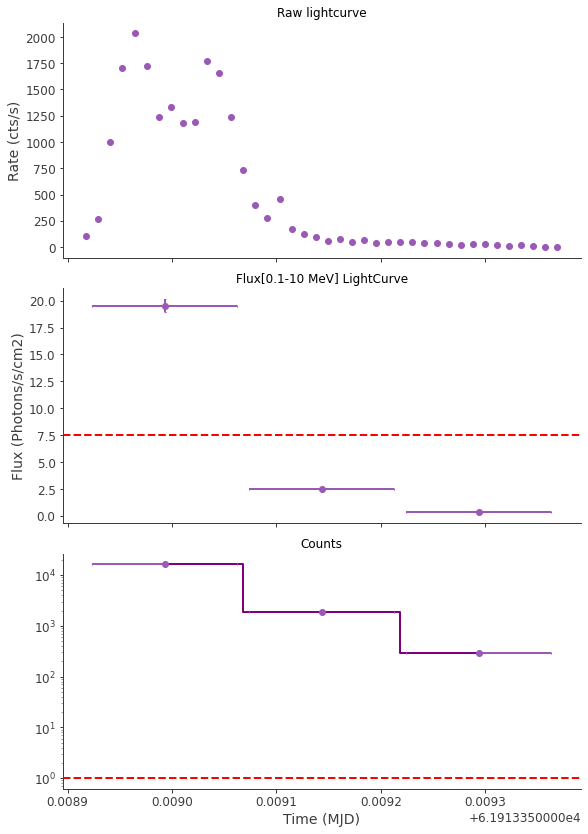

In [19]:
#
#Plot the time series of counts and fluxes
#
time_mjd=Time(time,format='unix').mjd
tmeds_mjd=Time(tmeds_lc, format='unix').mjd
e_tmeds_mjd=TimeDelta(e_tmeds_lc, format='sec').to('day').value
simulated_flux=7.5057 

cm = 1/2.54
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(21*cm, 29.7*cm))
#
# Raw Lightcurve
axs[0].scatter (time_mjd, rate)
axs[0].set_title('Raw lightcurve')
axs[0].set_ylabel('Rate (cts/s)')
#
# Flux Lightcurve
axs[1].errorbar(tmeds_mjd, fls, xerr=e_tmeds_mjd, yerr=[e_low_fls,e_hi_fls],fmt='o', capsize=1)
axs[1].set_title('Flux[0.1-10 MeV] LightCurve')
axs[1].set_ylabel('Flux (Photons/s/cm2)')
axs[1].axhline(y=simulated_flux, color='red', linestyle='--')
#
#Counts in log scale. To check that the fits have reasonable statistics.
axs[2].set_yscale('log')
axs[2].step(tmeds_mjd, cts_lc, where='mid',color='purple')
axs[2].errorbar (tmeds_mjd, cts_lc,xerr=e_tmeds_mjd,fmt='o', capsize=1)
axs[2].set_title('Counts')
axs[2].set_xlabel('Time (MJD)')
axs[2].axhline(y=1, color='red', linestyle='--')
#
#
# Adjust spacing between subplots
plt.tight_layout()
plt.savefig("eqslice_raw_flux_counts_lc.pdf", dpi=300)

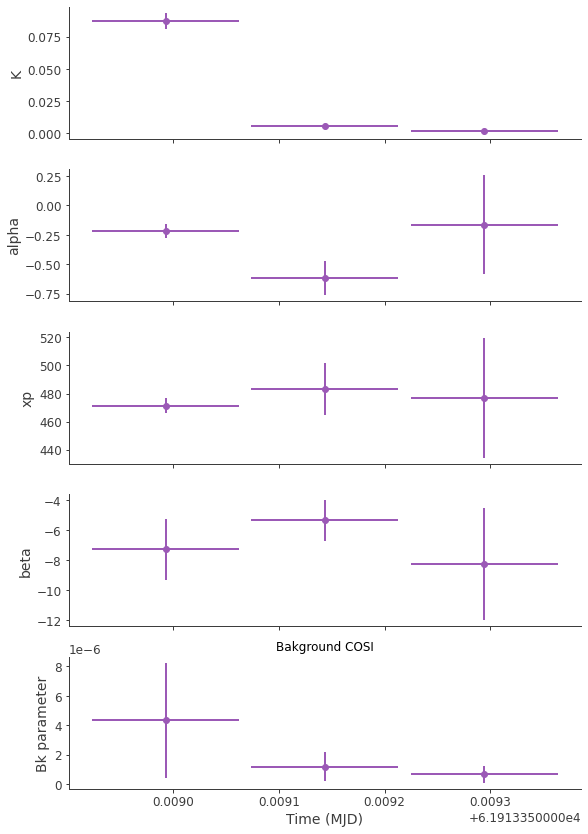

In [20]:
#
#Plot parameters as a function of time
#
npar=len(par_list)
cm = 1/2.54 
fig, axs = plt.subplots(npar+1, 1, sharex=True, figsize=(21*cm, 29.7*cm))

h=np.arange(0, 2*npar, 2)
for i in range(npar):
    axs[i].errorbar(tmeds_mjd, lc_par[:,h[i]], xerr=e_tmeds_mjd, yerr=lc_par[:,h[i]+1], fmt='o', capsize=0)
    axs[i].set_ylabel(par_list[i])

axs[npar].errorbar(tmeds_mjd, pars_bk, xerr=e_tmeds_mjd, yerr=epars_bk, fmt='o')
axs[npar].set_title('Bakground COSI')
axs[npar].set_xlabel('Time (MJD)')
axs[npar].set_ylabel('Bk parameter')

# Adjust spacing between subplots
plt.tight_layout()
plt.savefig("eqslice_specpars_bk_lc.pdf", dpi=300)

# Time series in variable time slices

Now we run the same procedure using time slices that are determined required a mininum signal to noise of 30. In this way the resulting light-curve is more densely sampled in the rising phase of the burst allowing the possibility to display finer details.

In [21]:
"""
Create slices with a minimun signal to noise. Change max_slices and min_sn as you wish. 
However, If max_slices is too large (i.e. leading to a slicing that is smaller 
than the native 0.5 s binning of the dataset), the function will return an error
"""
max_slices=20
min_sn=30
yaml_path=data_path / "grb.yaml"
hdf5_path=data_path / "grb_bkg_binned_data.hdf5"
tmins,tmaxs=make_minsn_tslices(tstart,tstop,yaml_path,hdf5_path,min_sn,max_slices)


23:41:01 INFO      set the minimizer to minuit                                             ]8;id=339353;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=264481;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


23:41:35 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=464734;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=828601;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

         WARNING   91.4 percent of samples have been thrown away because they failed the   ]8;id=202112;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=790360;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Band.K,(6.1 -1.0 +1.1) x 10^-2,1 / (cm2 keV s)
source.spectrum.main.Band.alpha,(-0.6 +/- 1.3) x 10^-1,
source.spectrum.main.Band.xp,(4.86 +/- 0.12) x 10^2,keV
source.spectrum.main.Band.beta,(-1.5 +/- 3.2) x 10,
background_cosi,(0.0 +/- 1.7) x 10^-7,


Correlation matrix:

1.00,0.97,-0.40,-0.00,-0.00
0.97,1.00,-0.18,-0.00,-0.00
-0.40,-0.18,1.00,0.00,0.00
-0.00,-0.00,0.00,1.00,0.00
-0.00,-0.00,0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,12021.657853
total,12021.657853


Values of statistical measures:

,statistical measures
AIC,24041.315705
BIC,24043.315705


processing MLE analyses:   0%|                                                           | 0/1 [00:00<?, ?it/s…


WARNING RuntimeWarning: divide by zero encountered in true_divide


WARNING RuntimeWarning: invalid value encountered in true_divide



23:41:40 INFO      set the minimizer to minuit                                             ]8;id=324427;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=459659;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


23:42:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=702489;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=567935;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

         WARNING   97.3 percent of samples have been thrown away because they failed the   ]8;id=34840;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=267281;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Band.K,(6.1 -1.2 +1.5) x 10^-2,1 / (cm2 keV s)
source.spectrum.main.Band.alpha,(-2.5 +/- 1.7) x 10^-1,
source.spectrum.main.Band.xp,(4.61 -0.15 +0.16) x 10^2,keV
source.spectrum.main.Band.beta,(-1 +/- 9) x 10,
background_cosi,(0 +/- 4) x 10^-7,


Correlation matrix:

1.00,0.97,-0.30,-0.00,-0.00
0.97,1.00,-0.09,-0.00,-0.00
-0.30,-0.09,1.00,0.00,-0.00
-0.00,-0.00,0.00,1.00,0.00
-0.00,-0.00,-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,7975.64608
total,7975.64608


Values of statistical measures:

,statistical measures
AIC,15949.292159
BIC,15951.292159


processing MLE analyses:   0%|                                                           | 0/1 [00:00<?, ?it/s…


WARNING RuntimeWarning: divide by zero encountered in true_divide


WARNING RuntimeWarning: invalid value encountered in true_divide



23:42:03 INFO      set the minimizer to minuit                                             ]8;id=492978;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=263118;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


23:42:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=690532;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=255874;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

         WARNING   97.18 percent of samples have been thrown away because they failed the  ]8;id=421957;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=870416;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Band.K,(4.4 -1.0 +1.2) x 10^-2,1 / (cm2 keV s)
source.spectrum.main.Band.alpha,(-2.9 +/- 1.9) x 10^-1,
source.spectrum.main.Band.xp,(4.68 +/- 0.18) x 10^2,keV
source.spectrum.main.Band.beta,(-0.1 +/- 1.0) x 10^2,
background_cosi,(0 +/- 9) x 10^-7,


Correlation matrix:

1.00,0.97,-0.32,-0.00,0.00
0.97,1.00,-0.10,-0.00,0.00
-0.32,-0.10,1.00,0.00,0.00
-0.00,-0.00,0.00,1.00,-0.00
0.00,0.00,0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,6428.624239
total,6428.624239


Values of statistical measures:

,statistical measures
AIC,12855.248478
BIC,12857.248478


processing MLE analyses:   0%|                                                           | 0/1 [00:00<?, ?it/s…


WARNING RuntimeWarning: divide by zero encountered in true_divide


WARNING RuntimeWarning: invalid value encountered in true_divide



23:42:21 INFO      set the minimizer to minuit                                             ]8;id=667664;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=103988;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


23:42:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=438272;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=475643;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

         WARNING   92.88 percent of samples have been thrown away because they failed the  ]8;id=904512;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=890773;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Band.K,(4.4 -1.0 +1.4) x 10^-2,1 / (cm2 keV s)
source.spectrum.main.Band.alpha,(-2.1 +/- 2.0) x 10^-1,
source.spectrum.main.Band.xp,(4.60 -0.18 +0.19) x 10^2,keV
source.spectrum.main.Band.beta,(-1 +/- 4) x 10,
background_cosi,(0 +/- 4) x 10^-7,


Correlation matrix:

1.00,0.97,-0.31,0.00,-0.00
0.97,1.00,-0.09,0.00,-0.00
-0.31,-0.09,1.00,-0.00,0.00
0.00,0.00,-0.00,1.00,-0.00
-0.00,-0.00,0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,5891.730924
total,5891.730924


Values of statistical measures:

,statistical measures
AIC,11781.461847
BIC,11783.461847


processing MLE analyses:   0%|                                                           | 0/1 [00:00<?, ?it/s…


WARNING RuntimeWarning: divide by zero encountered in true_divide


WARNING RuntimeWarning: invalid value encountered in true_divide



23:42:37 INFO      set the minimizer to minuit                                             ]8;id=455164;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=617709;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


23:42:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=642476;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=198881;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

         WARNING   96.26 percent of samples have been thrown away because they failed the  ]8;id=457301;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=532925;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Band.K,(6.6 -1.4 +1.7) x 10^-2,1 / (cm2 keV s)
source.spectrum.main.Band.alpha,(-1.8 +/- 1.8) x 10^-1,
source.spectrum.main.Band.xp,(4.51 +/- 0.15) x 10^2,keV
source.spectrum.main.Band.beta,(-1 +/- 7) x 10,
background_cosi,(0.0 +/- 1.3) x 10^-6,


Correlation matrix:

1.00,0.97,-0.29,-0.01,0.00
0.97,1.00,-0.08,-0.01,0.00
-0.29,-0.08,1.00,0.00,-0.00
-0.01,-0.01,0.00,1.00,-0.00
0.00,0.00,-0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,7598.362652
total,7598.362652


Values of statistical measures:

,statistical measures
AIC,15194.725305
BIC,15196.725305


processing MLE analyses:   0%|                                                           | 0/1 [00:00<?, ?it/s…


WARNING RuntimeWarning: divide by zero encountered in true_divide


WARNING RuntimeWarning: invalid value encountered in true_divide



23:43:00 INFO      set the minimizer to minuit                                             ]8;id=763742;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=530032;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


23:43:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=311075;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=964725;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

         WARNING   50.36000000000001 percent of samples have been thrown away because they ]8;id=758001;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=127446;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py#1740\1740]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Band.K,(1.56 -0.30 +0.4) x 10^-2,1 / (cm2 keV s)
source.spectrum.main.Band.alpha,(-5.4 +/- 1.7) x 10^-1,
source.spectrum.main.Band.xp,(5.05 -0.22 +0.23) x 10^2,keV
source.spectrum.main.Band.beta,-5.2 +/- 1.3,
background_cosi,(0 +/- 5) x 10^-6,


Correlation matrix:

1.00,0.97,-0.39,0.10,-0.00
0.97,1.00,-0.17,0.08,-0.00
-0.39,-0.17,1.00,-0.15,0.00
0.10,0.08,-0.15,1.00,-0.00
-0.00,-0.00,0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,6877.48605
total,6877.48605


Values of statistical measures:

,statistical measures
AIC,13752.9721
BIC,13754.9721


processing MLE analyses:   0%|                                                           | 0/1 [00:00<?, ?it/s…


WARNING RuntimeWarning: divide by zero encountered in true_divide


WARNING RuntimeWarning: invalid value encountered in true_divide



23:43:30 INFO      set the minimizer to minuit                                             ]8;id=396377;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=504536;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


23:44:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=869199;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=698858;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

         WARNING   98.61999999999999 percent of samples have been thrown away because they ]8;id=398528;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=513306;file:///Users/lauradigesu/opt/anaconda3/lib/python3.9/site-packages/threeML/analysis_results.py#1740\1740]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Band.K,(1.8 -0.4 +0.5) x 10^-3,1 / (cm2 keV s)
source.spectrum.main.Band.alpha,(-6.5 +/- 1.9) x 10^-1,
source.spectrum.main.Band.xp,(4.87 -0.24 +0.26) x 10^2,keV
source.spectrum.main.Band.beta,(-0.1 +/- 1.7) x 10^2,
background_cosi,(0.0 +/- 2.4) x 10^-6,


Correlation matrix:

1.00,0.96,-0.28,-0.00,-0.00
0.96,1.00,-0.05,-0.00,-0.00
-0.28,-0.05,1.00,0.00,-0.00
-0.00,-0.00,0.00,1.00,0.00
-0.00,-0.00,-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,5449.135669
total,5449.135669


Values of statistical measures:

,statistical measures
AIC,10896.271338
BIC,10898.271338


processing MLE analyses:   0%|                                                           | 0/1 [00:00<?, ?it/s…


WARNING RuntimeWarning: divide by zero encountered in true_divide


WARNING RuntimeWarning: invalid value encountered in true_divide



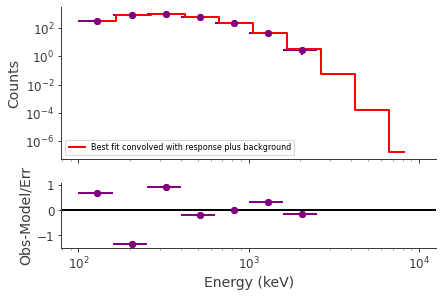

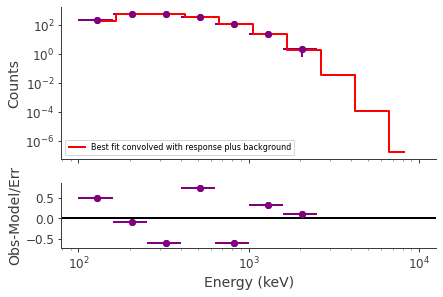

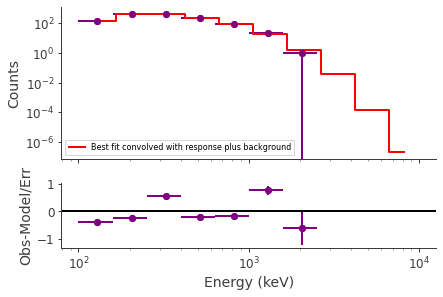

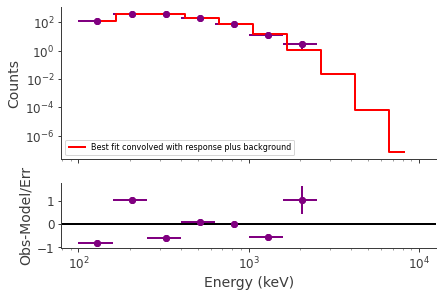

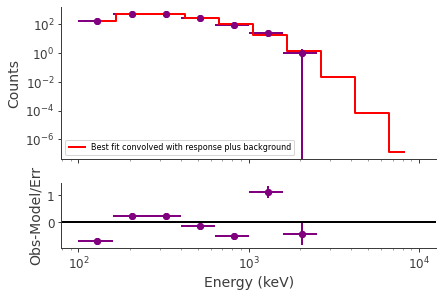

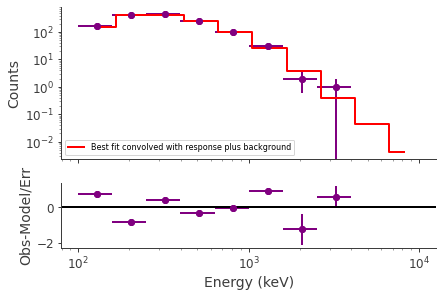

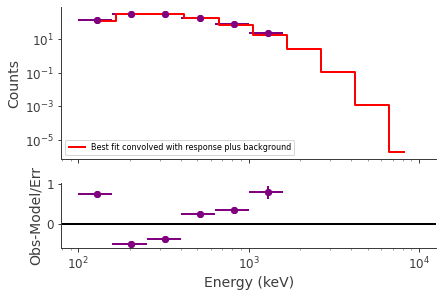

In [22]:
#
#Initialize empty vectors that will be filled at each step.
#
tmins_lc=np.array([])
tmaxs_lc=np.array([])
tmeds_lc=np.array([])
e_tmeds_lc=np.array([])
#
cts_lc=np.array([])
fls=np.array([])
e_low_fls=np.array([])
e_hi_fls=np.array([])
#
pars_bk=np.array([])
epars_bk=np.array([])
#
par_epar=np.array([])
#
for i in range(len(tmaxs)):
    #
    #LOOP over our N time bins.
    #
    #
    #The background is taken in a larger time window than the GRB to have enough counts.
    #
    bkg_tmin = 1842597310.0
    bkg_tmax = 1842597550.0
    bkg_min = np.where(bkg.binned_data.axes['Time'].edges.value == bkg_tmin)[0][0]
    bkg_max = np.where(bkg.binned_data.axes['Time'].edges.value == bkg_tmax)[0][0]
    #
    #Slice the orientation file into the time interval
    #
    ori_min = Time(tmins[i],format = 'unix')
    ori_max = Time(tmaxs[i],format = 'unix')
    sc_orientation = ori.source_interval(ori_min, ori_max)
    #
    #
    #Find the index of time axes corresponding to the limits of the tmins[i],tmaxs[i].
    #These are used to slice the data in time in the fit setup.
    #
    sou_min = np.where(grb_bkg.binned_data.axes['Time'].edges.value >= tmins[i])[0][0]
    sou_max_all = np.where(grb_bkg.binned_data.axes['Time'].edges.value <= tmaxs[i])
    y=len(sou_max_all[0])-1
    sou_max=np.where(grb_bkg.binned_data.axes['Time'].edges.value <= tmaxs[i])[0][y]
    #
    #Save the time bin edges and middle points for plotting later.
    #
    tmin_lc=grb_bkg.binned_data.axes['Time'].edges.value[sou_min]
    tmins_lc=np.append(tmins_lc,tmin_lc)
    #
    tmax_lc=grb_bkg.binned_data.axes['Time'].edges.value[sou_max]
    tmaxs_lc=np.append(tmaxs_lc,tmax_lc)
    #
    dt=(tmax_lc-tmin_lc) #total duration of the time bin
    tmed_lc=tmin_lc+0.5*dt#midpoint of time bins
    tmeds_lc=np.append(tmeds_lc,tmed_lc)#midpoints of the time bin
    hdt=dt/2 #half duration of the time bin i.e symmetric error for t_med
    e_tmeds_lc=np.append(e_tmeds_lc,hdt)#half duration of the time bin i.e symmetric error for t_med
    #
    #Define the background parameters
    #
    #
    bkg_par = Parameter("background_cosi",                                                                          # background parameter
                    0.1,                                                                                        # initial value of parameter
                    min_value=0,                                                                                # minimum value of parameter
                    max_value=5,                                                                                # maximum value of parameter
                    delta=1e-3,                                                                                 # initial step used by fitting engine
                    desc="Background parameter for cosi")
    #
    #
    #HERE's the key point. In the fit setup data, the grb_bkg data are sliced in Time in the interval tmins[i],tmaxs[i]
    #
    cosi = COSILike("cosi",                                                                                         # COSI 3ML plugin
                    dr = dr,                                                                                        # detector response
                    data = grb_bkg.binned_data.slice[{'Time':slice(sou_min,sou_max)}].project('Em', 'Phi', 'PsiChi'), # data (source+background)
                    bkg = bkg.binned_data.slice[{'Time':slice(bkg_min,bkg_max)}].project('Em', 'Phi', 'PsiChi'),    # background model 
                    sc_orientation = sc_orientation,                                                                # spacecraft orientation
                    nuisance_param = bkg_par)  # background parameter

    #
    
    source = PointSource("source",                 # Name of source (arbitrary, but needs to be unique)
                     l = l,                        # Longitude (deg)
                     b = b,                        # Latitude (deg)
                     spectral_shape = spectrum)    # Spectral model

    model = Model(source)  # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

    # Optional: if you want to call get_log_like manually, then you also need to set the model manually
    # 3ML does this internally during the fit though
    cosi.set_model(model)    
    plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)
    #
    like = JointLikelihood(model, plugins, verbose = False)
    like.fit()
    results = like.results
    #
    #
    #Obtain counts in time slices:
    #
    cts=np.sum(grb_bkg.binned_data.slice[{'Time':slice(sou_min,sou_max)}])
    cts_lc=np.append(cts_lc,cts)
    #
    #Obtain parameters:
    #
    #bk
    #
    par_bk=results.get_variates("background_cosi").median
    pars_bk=np.append(pars_bk,par_bk)
    epar_bk=results.get_variates("background_cosi").std
    epars_bk=np.append(epars_bk,epar_bk)   
    #
    #These are dictionaries of parameters values and errors.
    #
    par_bf= {par.name:results.get_variates(par.path).median
                  for par in results.optimized_model["source"].parameters.values()
                  if par.free}
    #
    epar_bf= {par.name:results.get_variates(par.path).std
                  for par in results.optimized_model["source"].parameters.values()
                  if par.free}
    #
    par_list = list(par_bf.keys()) #This is a list of the parameter names.
    for j in range(len(par_list)):
        par_epar=np.append(par_epar,par_bf[par_list[j]])
        par_epar=np.append(par_epar,epar_bf[par_list[j]])         
    #
    #Obtain fluxes:
    #Here I use the 3ML method to ge integrated flux in an energy range.
    #I use the energy range from the data 100--10000 keV
    #
    threeML_config.point_source.integrate_flux_method = "trapz"
    result_fl=results.get_flux(
        ene_min=100. * u.keV,
        ene_max= 10000.* u.keV,
        confidence_level=0.95,
        sum_sources=True,
        flux_unit="1/(cm2 s)"
    )
    #
    fl=result_fl["flux"].values[0].value
    fls=np.append(fls,fl)
    e_low_fl=np.abs(result_fl["low bound"].values[0].value-fl)
    e_low_fls=np.append(e_low_fls, e_low_fl)
    e_hi_fl=result_fl["hi bound"].values[0].value-fl
    e_hi_fls=np.append(e_hi_fls, e_hi_fl)
    #
    #
    #Save a plot of the current fit.
    #
    ene = np.array([])
    e_ene = np.array([])
    #
    binned_energy_edges = grb.binned_data.axes['Em'].edges.value
    for j in range(len(binned_energy_edges) - 1):
        delta_ene=(binned_energy_edges[j + 1]-binned_energy_edges[j])
        ene= np.append(ene, (binned_energy_edges[j]+0.5*delta_ene))
        e_ene = np.append(e_ene, 0.5*delta_ene)
    #
    #
    cts_obs=grb_bkg.binned_data.slice[{'Time':slice(sou_min,sou_max)}].project('Em').todense().contents
    e_cts_obs=np.sqrt(cts_obs)
    #
    expectation = cosi._expected_counts['source']
    cts_exp=expectation.project('Em').todense().contents + (bkg_par.value * bkg.binned_data.slice[{'Time':slice(bkg_min,bkg_max)}].project('Em').todense().contents)
    #
    resid=(cts_obs-cts_exp)/e_cts_obs
    e_resid=(e_cts_obs/cts_obs)*resid
    #
    cm = 1 / 2.54
    #
    fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [0.7, 0.3]})
    fig.tight_layout()
    #
    ax[0].scatter(ene, cts_obs, color='purple')
    ax[0].errorbar(ene, cts_obs, xerr=e_ene, yerr=e_cts_obs, color='purple', fmt='o', capsize=0)
    #
    ax[0].step(ene, cts_exp, where='mid', color='red', label="Best fit convolved with response plus background")
    #
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[0].set_ylabel("Counts")
    ax[0].legend()
    #
    #
    #
    ax[1].errorbar(ene, resid, xerr=e_ene, yerr=e_resid, color='purple', fmt='o', capsize=0)
    ax[1].errorbar(ene, resid, xerr=e_ene, yerr=e_resid, color='purple', fmt='o', capsize=0)
    ax[1].axhline(y=0, color='black')
    ax[1].set_xscale("log")
    ax[1].set_yscale("linear")
    ax[1].set_ylabel("Obs-Model/Err")
    ax[1].set_xlabel("Energy (keV)")
    #
    plt.savefig(str("minsnslice_fit_"+str(i)+".pdf"), dpi=300)
#
#Save lc in in a text file:
#
lc=np.vstack((tmeds_lc,e_tmeds_lc,cts_lc,fls,e_low_fls,e_hi_fls,pars_bk,epars_bk)).T
nbins=len(tmeds_lc)
npars=2*len(par_list)
lc_par=par_epar.reshape(nbins,npars)
lc_all=np.hstack((lc,lc_par))
fl_list=['t','e_t','cts','fl','e+_fl','e-_fl','bk','e_bk']
par_list = list(par_bf.keys())
header=fl_list+par_list
np.savetxt("minsnslice_spec_lc.dat", lc_all, delimiter=" ",header=str(header))



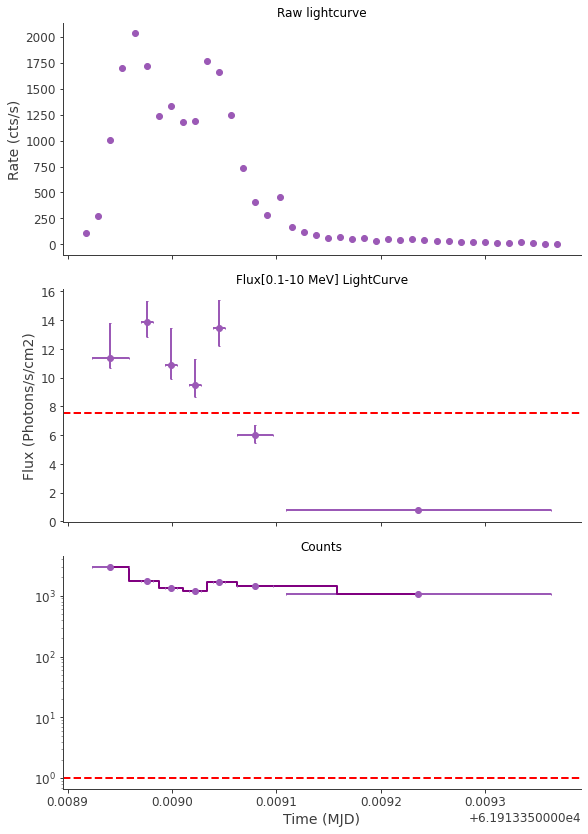

In [23]:
#
#Plot the time series of counts and fluxes
#
time_mjd=Time(time,format='unix').mjd
tmeds_mjd=Time(tmeds_lc, format='unix').mjd
e_tmeds_mjd=TimeDelta(e_tmeds_lc, format='sec').to('day').value
simulated_flux=7.5057 

cm = 1/2.54
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(21*cm, 29.7*cm))
#
# Raw Lightcurve
axs[0].scatter (time_mjd, rate)
axs[0].set_title('Raw lightcurve')
axs[0].set_ylabel('Rate (cts/s)')
#
# Flux Lightcurve
axs[1].errorbar(tmeds_mjd, fls, xerr=e_tmeds_mjd, yerr=[e_low_fls,e_hi_fls],fmt='o', capsize=1)
axs[1].set_title('Flux[0.1-10 MeV] LightCurve')
axs[1].set_ylabel('Flux (Photons/s/cm2)')
axs[1].axhline(y=simulated_flux, color='red', linestyle='--')
#
#Counts in log scale. To check that the fits have reasonable statistics.
axs[2].set_yscale('log')
axs[2].step(tmeds_mjd, cts_lc, where='mid',color='purple')
axs[2].errorbar (tmeds_mjd, cts_lc,xerr=e_tmeds_mjd,fmt='o', capsize=1)
axs[2].set_title('Counts')
axs[2].set_xlabel('Time (MJD)')
axs[2].axhline(y=1, color='red', linestyle='--')
#
#
# Adjust spacing between subplots
plt.tight_layout()
plt.savefig("minsnslice_raw_flux_counts_lc.pdf", dpi=300)

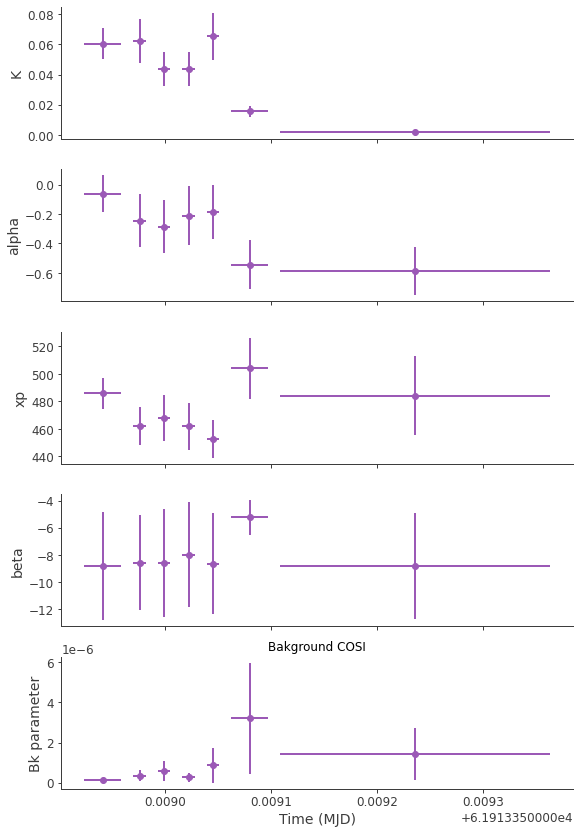

In [24]:
#
#Plot parameters as a function of time
#
npar=len(par_list)
cm = 1/2.54 
fig, axs = plt.subplots(npar+1, 1, sharex=True, figsize=(21*cm, 29.7*cm))

h=np.arange(0, 2*npar, 2)
for i in range(npar):
    axs[i].errorbar(tmeds_mjd, lc_par[:,h[i]], xerr=e_tmeds_mjd, yerr=lc_par[:,h[i]+1], fmt='o', capsize=0)
    axs[i].set_ylabel(par_list[i])

axs[npar].errorbar(tmeds_mjd, pars_bk, xerr=e_tmeds_mjd, yerr=epars_bk, fmt='o')
axs[npar].set_title('Bakground COSI')
axs[npar].set_xlabel('Time (MJD)')
axs[npar].set_ylabel('Bk parameter')

# Adjust spacing between subplots
plt.tight_layout()
plt.savefig("minsnslice_specpars_bk_lc.pdf", dpi=300)